**Activity 1**
Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. 
Plot the train and validation loss curves of all autoencoders in the same figure.
4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. 
Show the results in a table, including #params of each model.
5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.
6. Generate 5 new images by injecting random values as input to the decoder. Show them.


OBTAIN LIBRARIES AND IMPORTS


In [0]:
import torch
import copy
import random
import numpy as np
np.random.seed(7) # To obtain reproducible results
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(1)
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms
import plotly.graph_objects as go

In [0]:
#constants
Neck_Sizes = [50,30]
NumNeckSizes = len(Neck_Sizes)
TraiSetSize = 60000
SplitTraning = 95
SplitTraningSize = int(TraiSetSize*SplitTraning/100)
SpitValidationSize = TraiSetSize-SplitTraningSize

# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':5,
    'test_batch_size':64,
    'eval_batch_size': 64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck':30,
    'NumImages':5,
    'ex2_batch_size':100
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.manual_seed_all(7)
# whenever we send something to the selected device (X.to(device)) we already use
# either CPU or CUDA (GPU). Importantly...
# The .to() operation is in-place for nn.Module's, so network.to(device) suffices
# The .to() operation is NOT in.place for tensors, so we must assign the result
# to some tensor, like: X =out X.to(device)




**EXERCISE 1.** Load MNIST train and test sets. Split the original training data 
into 95% training and 5% validation data. --> DONE


In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))

mnist_valset =copy.deepcopy(mnist_trainset)

mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

mnist_valset.data = mnist_trainset.data[SplitTraningSize:TraiSetSize]
mnist_valset.targets = mnist_trainset.targets[SplitTraningSize:TraiSetSize]

mnist_trainset.data = mnist_trainset.data[:SplitTraningSize]
mnist_trainset.targets = mnist_trainset.targets[:SplitTraningSize]

train_loader = torch.utils.data.DataLoader(
    mnist_trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

val_loader = torch.utils.data.DataLoader(
    mnist_valset,
    batch_size=hparams['eval_batch_size'], 
    shuffle=True)

print(mnist_trainset.data.shape)
print(mnist_trainset.targets.shape)

print(mnist_valset.data.shape)
print(mnist_valset.targets.shape)

0it [00:00, ?it/s]

9920512it [00:02, 3693155.95it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57882.05it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:01, 976545.48it/s]                             
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


8192it [00:00, 21984.13it/s]            

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!
torch.Size([57000, 28, 28])
torch.Size([57000])
torch.Size([3000, 28, 28])
torch.Size([3000])


Print a random image from the dataset.

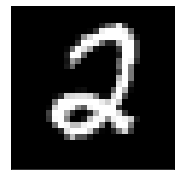

In [4]:
   
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)





**EXERCISE 2.** Implement a convolutional autoencoder (with separate Encoder and Decoder modules) --> DONE



In [0]:
class ConvEncoder(nn.Module):
  def __init__(self,bottlenecksize):
    super().__init__()
    ## encoder layers ##
    # conv layer (depth from 1 --> 16), 3x3 kernels
    self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
    # conv layer (depth from 16 --> 4), 3x3 kernels
    self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
    # pooling layer to reduce x-y dims by two; kernel and stride of 2
    self.pool = nn.MaxPool2d(2, 2)
    self.linear1=nn.Linear(7*7*4, bottlenecksize)
    self.linear2= nn.Linear(bottlenecksize, bottlenecksize)
    self.sigmoid=nn.Sigmoid()
   
  def forward(self,x):
      ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after  
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    # add second hidden layer
    x = F.relu(self.conv2(x))
    x = self.pool(x)  # compressed representation
    bsz, nch, height, width = x.shape
    x=x.view(bsz,-1)
    x=self.linear1(x)
    x= self.linear2(x)
    encoded=self.sigmoid(x)

    return encoded


class ConvDecoder(nn.Module):
  def __init__(self,bottlenecksize=hparams['bottleneck']):
     super().__init__()
      ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
     self.linear1=nn.Linear(bottlenecksize, bottlenecksize)
     self.linear2=nn.Linear(bottlenecksize, 7*7*4)
     self.sigmoid=nn.Sigmoid()
     self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

  def forward(self,x):
     ## decode ##
        # add transpose conv layers, with relu activation function
    x=self.linear1(x)
    x=self.linear2(x)
    x=self.sigmoid(x)
    #Recover the batch size
    upSize=x.size()
    x=x.view(upSize[0], 4, 7, 7)
    x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
    decoded = F.sigmoid(self.t_conv2(x))
    return decoded


# define the NN architecture
class ConvAutoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()

    self.cEnc = enc
    self.cDec = dec

  def forward(self, x):

    x = self.cEnc(x)
    decoded = self.cDec(x)

    return decoded

# initialize the NN
#cEncoder=ConvEncoder()
#cDecoder=ConvDecoder()

#model = ConvAutoencoder(cEncoder, cDecoder)

#print(model)

**EXERCISE 3**

Train the convolutional autoencoder, --> DONE

with different bottleneck sizes. --> DONE

 Plot the train and validation loss curves of all autoencoders in the same figure. --> DONE



Trainig model with Bottleneck size:50 and number of parameters: 26023



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Epoch: 1 	Training Loss: 50.450047093743564 error on image
Epoch: 2 	Training Loss: 39.38868182971154 error on image
Epoch: 3 	Training Loss: 37.437712805305935 error on image
Epoch: 4 	Training Loss: 36.526610982404684 error on image
Epoch: 5 	Training Loss: 35.82325889178532 error on image




Trainig model with Bottleneck size:30 and number of parameters: 14923

Epoch: 1 	Training Loss: 51.62902245270015 error on image
Epoch: 2 	Training Loss: 41.472716693257375 error on image
Epoch: 3 	Training Loss: 38.751607388625914 error on image
Epoch: 4 	Training Loss: 37.55521552142604 error on image
Epoch: 5 	Training Loss: 36.80511658868672 error on image


Text(0, 0.5, 'NLLLoss')

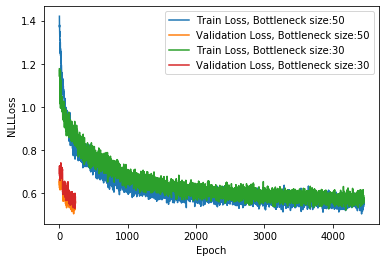

In [6]:
# number of epochs to train the model

n_epochs = hparams['num_epochs']
model_trained = []

for i in range (NumNeckSizes):
  cEncoder=ConvEncoder(Neck_Sizes[i])
  cDecoder=ConvDecoder(Neck_Sizes[i])
  model = ConvAutoencoder(cEncoder, cDecoder)

  criterion = nn.MSELoss()
  optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

  train_history = []
  val_history = []
  train2plot = []
  val2plot = []
  epocnum = []
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print('\n\nTrainig model with Bottleneck size:' + str(Neck_Sizes[i]) + ' and number of parameters: ' + str(params)+'\n')
  
  for epoch in range(1, n_epochs+1):
      # monitor training loss
      train_loss = 0.0
      epocnum.append(epoch)
      ###################
      # train the model #
      ###################
      for data in train_loader:
          # _ stands in for labels, here
          # no need to flatten images
          
          images, _ = data
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          outputs = model(images)

          # calculate the loss
          loss = criterion(outputs, images)
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update running training loss
          train2plot.append(loss.item())
          train_loss += loss.item()*images.size(0)

      
      val_loss = 0.0

      

      for data2 in val_loader:
          images2, _ = data2
          outputs = model(images2)

          loss = criterion(outputs, images2)
          val2plot.append(loss.item())
          val_loss += loss.item()*images2.size(0)
      
      val_loss = val_loss/len(val_loader)
      val_history.append(round(val_loss,3))

      # print avg training statistics 
      train_loss = train_loss/len(train_loader)
      train_history.append(round(train_loss,3))  
      print('Epoch: {} \tTraining Loss: {} error on image'.format(
          epoch, 
          train_loss
          ))
  # Save the learned model with the currect bottle neck on a model list
  model_trained.append(model)

  
  fig = go.Figure(data=[go.Table(header=dict(values=['Neck Size','Number of parameters', 'Validation Error', 'Train Error','Epoc']),
                 cells=dict(values=[Neck_Sizes[i],params,val_history,train_history,epocnum]))
                     ])
  fig.show()
  
  plt.plot(train2plot, label='Train Loss, Bottleneck size:' + str(Neck_Sizes[i]))
  plt.plot(val2plot, label='Validation Loss, Bottleneck size:' + str(Neck_Sizes[i]))

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

choosing a model

**EXERCISE 4**

Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model. Done in previous table.

In [0]:
#from torchsummary import summary

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
#model1 = ConvAutoencoder(cEncoder, cDecoder).to(device)
#summary(model1, (1, 28, 28))

**EXERCISE 5**

Select one of the autoencoders --> done

and feed it 5 random MNIST images from the test set. Show them along with their reconstructions. --> DONE

In [0]:
AverSize = np.sum(np.log(Neck_Sizes))/NumNeckSizes
AverSize=np.exp(AverSize)
ChooseSize = max(Neck_Sizes-AverSize)

for i in range (NumNeckSizes):
  if ( abs(Neck_Sizes[i]-AverSize) < ChooseSize ):
    ChooseSize = Neck_Sizes[i]-AverSize
    ChooseModelInd = i

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

This function is deprecated. Please call randint(1, 64 + 1) instead

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



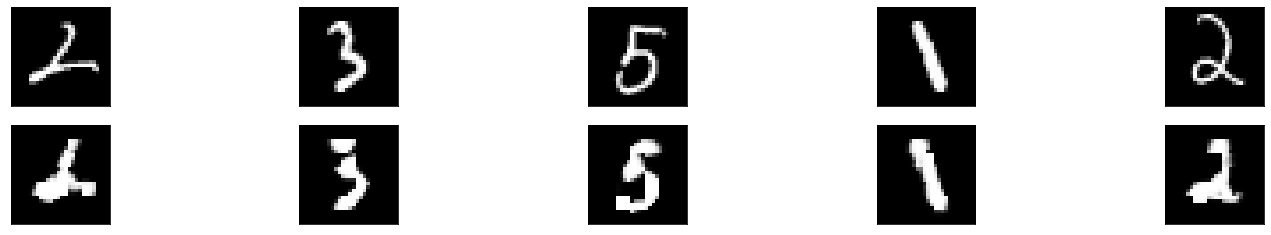

In [10]:
# obtain one batch of test images
n = hparams['NumImages']  # how many digits we will display

dataiter = iter(test_loader)
images, labels = dataiter.next()
ps=abs(np.random.random_integers(images.shape[0])-n)

# get sample outputs
images= images.data[ps:ps+n]
ChooseModel =model_trained[ChooseModelInd]
output = ChooseModel(images)

# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(n, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=n, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images+ps, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

**EXERCISE 6**

Generate 5 new images by injecting random values as input to the decoder. Show them. --> DONE :)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



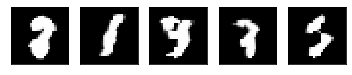

In [11]:
#Create a Decoder
x = torch.rand(hparams['batch_size'],Neck_Sizes[ChooseModelInd]) # --> bottle neck size

output = ChooseModel.cDec(x)

# output is resized into a batch of images
output = output.view(hparams['batch_size'], 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

for i in range(n):
    # display reconstruction
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(output[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()




**Activity 2**


1.   Select a subset of 100 images and their associated labels from the MNIST training data.
2. Select one of the previously trained autoencoders.
3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
4. Pre-training: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
5. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
6. From scratch: train the model on the 100 samples without reusing the decoder weights at all.
7. Show the accuracy of the four models on the MNIST test set in a table.






Exercise 1: Select a subset of 100 images and their associated labels from the 
MNIST training data.

In [12]:
# Create a copy to not trim the original trainset
mnist_traindata =copy.deepcopy(mnist_trainset)

ps=abs(np.random.random_integers(mnist_traindata.data.shape[0]-100))

# Take random 100 images
mnist_traindata.data = mnist_traindata.data[ps:ps+100]
mnist_traindata.targets = mnist_traindata.targets[ps:ps+100]
print(mnist_traindata.data.shape)
print(mnist_traindata.targets.shape)

traind_loader = torch.utils.data.DataLoader(
    mnist_traindata,
    batch_size=hparams['ex2_batch_size'], 
    shuffle=True)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(traind_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print('The Batched tensors return a collection of {} grayscale images ({} channel, {} height pixels, {} width pixels)'.format(bimg.shape[0],
                                                                                                                              bimg.shape[1],
                                                                                                                              bimg.shape[2],
                                                                                                                              bimg.shape[3]))


torch.Size([100, 28, 28])
torch.Size([100])
Batch Img shape:  torch.Size([100, 1, 28, 28])
Batch Label shape:  torch.Size([100])
The Batched tensors return a collection of 100 grayscale images (1 channel, 28 height pixels, 28 width pixels)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

This function is deprecated. Please call randint(1, 56900 + 1) instead



2. Select one of the previously trained autoencoders.

In [13]:
modelEx2 = ChooseModel
print(modelEx2)

ConvAutoencoder(
  (cEnc): ConvEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear1): Linear(in_features=196, out_features=30, bias=True)
    (linear2): Linear(in_features=30, out_features=30, bias=True)
    (sigmoid): Sigmoid()
  )
  (cDec): ConvDecoder(
    (linear1): Linear(in_features=30, out_features=30, bias=True)
    (linear2): Linear(in_features=30, out_features=196, bias=True)
    (sigmoid): Sigmoid()
    (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

In [0]:
# define the NN architecture
class Clasificator(nn.Module):
  def __init__(self,bottlenecksize):
    super().__init__()
    self.linear1=nn.Linear(bottlenecksize, hparams['hidden_size']),
    self.linear2=nn.Linear(hparams['hidden_size'], hparams['num_classes'])
    self.logsoftmax=nn.LogSoftmax()

  def forward(self,x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.linear2(x)
    clasif = self.logsoftmax(x)

    return clasif


class ClasificationModel(nn.Module):
  def __init__(self, enc, clasif):
    super().__init__()

    self.cEnc = enc
    self.cClasif = clasif

  def forward(self, x):

    x = self.cEnc(x)
    Clasified = self.cClasif(x)

    return Clasified

Time to train

In [15]:
criterion=F.nll_loss

cClasificator = Clasificator(Neck_Sizes[ChooseModelInd])
model = ClasificationModel(modelEx2.cEnc, cClasificator)
print(model)

optimizer=optim.RMSprop(params=model.parameters(), lr=hparams['learning_rate'], alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acu

avg_loss = None
avg_weight = 0.1

ClasificationModel(
  (cEnc): ConvEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear1): Linear(in_features=196, out_features=30, bias=True)
    (linear2): Linear(in_features=30, out_features=30, bias=True)
    (sigmoid): Sigmoid()
  )
  (cClasif): Clasificator(
    (linear2): Linear(in_features=128, out_features=10, bias=True)
    (logsoftmax): LogSoftmax()
  )
)


In [0]:
def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()

      data = data.view(data.shape[0], -1)
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss

In [0]:
def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.shape[0], -1)
            output = network(data)
            test_loss += criterion(output, target, reduction='sum').item() # sum up batch loss
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [18]:
# Init lists to save the evolution of the training & test losses/accuracy.
train_losses = []
test_losses = []
test_accs = []

for epoch in range(1, hparams['num_epochs'] + 1):
  train_losses.append(train_epoch(traind_loader, model, optimizer, criterion, hparams))

  test_loss,test_accuracy=test_epoch(test_loader, model, hparams)
  
  test_losses.append(test_loss)
  test_accs.append(test_accuracy)

RuntimeError: ignored

In [0]:
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(test_accs)